## [1.1] Loading the data

The data is already preprocessed and stored in an sql formal 

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import os

In [6]:
# # loading previous cleaned dataset
import sqlite3
con = sqlite3.connect("final.sqlite")

In [12]:
data = pd.read_sql_query("select * from Reviews", con)

In [13]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [14]:
data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [15]:
data.shape

(364171, 12)

## Observation
data is not balanced so we are using AUC for the parameter tuning

In [18]:
final = data
# Sort data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")
final['Score'] = (final.Score.str.match('positive')).astype(int)
final.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [23]:
#for brute force data sampling
#dividing the data in the ratio of 60:20:20 to train, Cv and test of total 30k
xTrainBrute, yTrainBrute, xCvBrute, yCvBrute, xTestBrute, yTestBrute = final.CleanedText[0:36000], final.Score[0:36000],final.CleanedText[36000:48000], final.Score[36000:48000],final.CleanedText[48000:60000], final.Score[48000:60000]
print("train data size is ", xTrainBrute.shape, " and result size is", yTrainBrute.shape)
print("cv data size is ", xCvBrute.shape, " and result size is", yCvBrute.shape)
print("test data size is ", xTestBrute.shape, " and result size is", yTestBrute.shape)

train data size is  (36000,)  and result size is (36000,)
cv data size is  (12000,)  and result size is (12000,)
test data size is  (12000,)  and result size is (12000,)


In [24]:
#for brute force data sampling
#dividing the data in the ratio of 70:30 to train and test of total 20k
xTrainKd, yTrainKd, xCvKd, yCvKd, xTestKd, yTestKd = final.CleanedText[0:12000], final.Score[0:12000],final.CleanedText[12000:16000], final.Score[12000:16000],final.CleanedText[16000:20000], final.Score[16000:20000]
print("train data size is ", xTrainKd.shape, " and result size is", yTrainKd.shape)
print("train data size is ", xCvKd.shape, " and result size is", yCvKd.shape)
print("test data size is ", xTestKd.shape, " and result size is", yTestKd.shape)

train data size is  (12000,)  and result size is (12000,)
train data size is  (4000,)  and result size is (4000,)
test data size is  (4000,)  and result size is (4000,)


# [2] Featurization

## [2.1] BAG OF WORDS

In [25]:
#BoW for Brute
bowBrute = CountVectorizer(max_features=2000, min_df=50) #in scikit-learn
trainBowBrute = bowBrute.fit_transform(xTrainBrute)
print(trainBowBrute.shape)
print(type(trainBowBrute))

cvBowBrute = bowBrute.transform(xCvBrute)
print(cvBowBrute.shape)
print(type(cvBowBrute))

testBowBrute = bowBrute.transform(xTestBrute)
print(testBowBrute.shape)
print(type(testBowBrute))

(36000, 2000)
<class 'scipy.sparse.csr.csr_matrix'>
(12000, 2000)
<class 'scipy.sparse.csr.csr_matrix'>
(12000, 2000)
<class 'scipy.sparse.csr.csr_matrix'>


In [26]:
#BoW for Kd-tree
bowKd = CountVectorizer(max_features=500, min_df=10) #in scikit-learn
trainBowKd = bowKd.fit_transform(xTrainKd)
print(trainBowKd.shape)
print(type(trainBowKd))
trainBowKd = trainBowKd.todense()
print(type(trainBowKd))

cvBowKd = bowKd.transform(xCvKd)
print(cvBowKd.shape)
print(type(cvBowKd))
cvBowKd = cvBowKd.todense()
print(type(cvBowKd))

testBowKd = bowKd.transform(xTestKd)
print(testBowKd.shape)
print(type(testBowKd))
testBowKd = testBowKd.todense()
print(type(testBowKd))


(12000, 500)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>
(4000, 500)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>
(4000, 500)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


## [2.2] TF-IDF

In [27]:
#tfidf Brute
tfidfBrute = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=2000)
trainTfBrute = tfidfBrute.fit_transform(xTrainBrute)
print(trainTfBrute.shape)
print(type(trainTfBrute))

cvTfBrute = tfidfBrute.transform(xCvBrute)
print(cvTfBrute.shape)
print(type(cvTfBrute))

testTfBrute = tfidfBrute.transform(xTestBrute)
print(testTfBrute.shape)
print(type(testTfBrute))

(36000, 2000)
<class 'scipy.sparse.csr.csr_matrix'>
(12000, 2000)
<class 'scipy.sparse.csr.csr_matrix'>
(12000, 2000)
<class 'scipy.sparse.csr.csr_matrix'>


In [28]:
#tfidf Kd
tfidfKd = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
trainTfKd = tfidfKd.fit_transform(xTrainKd)
print(trainTfKd.shape)
print(type(trainTfKd))
trainTfKd = trainTfKd.todense()
print(type(trainTfKd))

cvTfKd = tfidfKd.transform(xCvKd)
print(cvTfKd.shape)
print(type(cvTfKd))
cvTfKd = cvTfKd.todense()
print(type(cvTfKd))


testTfKd = tfidfKd.transform(xTestKd)
print(testTfKd.shape)
print(type(testTfKd))
testTfKd = testTfKd.todense()
print(type(testTfKd))

(12000, 500)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>
(4000, 500)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>
(4000, 500)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


## [2.3] Word2Vec

#### [2.3.1] Avg W2v Brute

In [29]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [30]:
#word2vec
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent = []
for sent in xTrainBrute.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [31]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 


In [32]:
w2v = w2v_model[w2v_model.wv.vocab]

In [33]:
w2v.shape

(8034, 50)

In [34]:
w2v_model.wv.most_similar('similar')

[('typic', 0.7504246830940247),
 ('unlik', 0.6749457716941833),
 ('lighter', 0.6520532965660095),
 ('appeal', 0.6445991396903992),
 ('superior', 0.6308809518814087),
 ('lack', 0.6198273301124573),
 ('graini', 0.619362473487854),
 ('decent', 0.6182388067245483),
 ('fantast', 0.616011381149292),
 ('richer', 0.6153573989868164)]

In [35]:
# average Word2Vec on train data brute
trainBrute = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    trainBrute.append(sent_vec)
print(len(trainBrute))
print(len(trainBrute[0]))
# To replace nan with 0 and inf with large finite number

trainAvgBrute = np.nan_to_num(trainBrute)

36000
50


In [36]:
# average Word2Vec on cross validate data brute
list_of_sent_cv = []
for sent in xCvBrute.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_cv.append(filtered_sentence)
    
# average Word2Vec on train data
cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    cv.append(sent_vec)
print(len(cv))
print(len(cv[0]))
# To replace nan with 0 and inf with large finite number

cvAvgBrute = np.nan_to_num(cv)

12000
50


In [37]:
# average Word2Vec on test data brute
list_of_sent_test = []
for sent in xTestBrute.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
    
# average Word2Vec on train data
test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    test.append(sent_vec)
print(len(test))
print(len(test[0]))
# To replace nan with 0 and inf with large finite number

testAvgBrute = np.nan_to_num(test)

12000
50


#### [2.3.2] TFIDF weighted W2v Brute

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidfBrute.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    train1.append(sent_vec)
    row += 1
    
trainTfW2vBrute = np.nan_to_num(train1)
len(trainTfW2vBrute)

36000

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidfBrute.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    cv1.append(sent_vec)
    row += 1
    
cvTfW2vBrute = np.nan_to_num(cv1)    
len(cvTfW2vBrute)

12000

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidfBrute.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    test1.append(sent_vec)
    row += 1
    
testTfW2vBrute = np.nan_to_num(test1)
len(testTfW2vBrute)

12000

### [2.3.1] Avg w2v kd tree

In [41]:
#word2vec
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent = []
for sent in xTrainKd.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [42]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 


In [43]:
w2v = w2v_model[w2v_model.wv.vocab]

In [44]:
w2v.shape

(5107, 50)

In [45]:
w2v_model.wv.most_similar('similar')

[('domin', 0.9347849488258362),
 ('describ', 0.9214526414871216),
 ('except', 0.9209932684898376),
 ('authent', 0.9183551669120789),
 ('milder', 0.9181166291236877),
 ('incred', 0.9174165725708008),
 ('lighter', 0.9171276092529297),
 ('typic', 0.9128759503364563),
 ('malt', 0.9121532440185547),
 ('agav', 0.9120005965232849)]

In [46]:
# average Word2Vec on train data kd
trainKd = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    trainKd.append(sent_vec)
print(len(trainKd))
print(len(trainKd[0]))
# To replace nan with 0 and inf with large finite number

trainAvgKd = np.nan_to_num(trainKd)

12000
50


In [47]:
# average Word2Vec on cross validate data brute
list_of_sent_cv = []
for sent in xCvKd.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_cv.append(filtered_sentence)
    
# average Word2Vec on train data
cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    cv.append(sent_vec)
print(len(cv))
print(len(cv[0]))
# To replace nan with 0 and inf with large finite number

cvAvgKd = np.nan_to_num(cv)

4000
50


In [48]:
# average Word2Vec on test data brute
list_of_sent_test = []
for sent in xTestKd.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
    
# average Word2Vec on train data
test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    test.append(sent_vec)
print(len(test))
print(len(test[0]))
# To replace nan with 0 and inf with large finite number

testAvgKd = np.nan_to_num(test)

4000
50


### [2.3.2] TfIdf w2v Kdtree

In [49]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidfKd.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    train1.append(sent_vec)
    row += 1
    
trainTfW2vKd = np.nan_to_num(train1)
len(trainTfW2vKd)

12000

In [50]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidfKd.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    cv1.append(sent_vec)
    row += 1
    
cvTfW2vKd = np.nan_to_num(cv1)    
len(cvTfW2vKd)

4000

In [51]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidfKd.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    test1.append(sent_vec)
    row += 1
    
testTfW2vKd = np.nan_to_num(test1)
len(testTfW2vKd)

4000

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [52]:
from prettytable import PrettyTable
#initialing the table
tableData = PrettyTable()
tableData.field_names = ["Vectorizer", "Model", "K", "AUC"]
print(tableData)

+------------+-------+---+-----+
| Vectorizer | Model | K | AUC |
+------------+-------+---+-----+
+------------+-------+---+-----+


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [61]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

k = [i for i in range(1,30,2)]
aucTrain = []
aucCv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors= i, algorithm = 'brute')
    model.fit(trainBowBrute, yTrainBrute)
    
    predTrain = model.predict_proba(trainBowBrute)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTrainBrute, predTrain[:,1])
    aucTrain.append(metrics.auc(fpr, tpr))
    
    predCv = model.predict_proba(cvBowBrute)
    
    fpr, tpr, thresholds = metrics.roc_curve(yCvBrute, predCv[:,1])
    aucCv.append(metrics.auc(fpr, tpr))
    print(i, " neighour done")

1  neighour done
3  neighour done
5  neighour done
7  neighour done
9  neighour done
11  neighour done
13  neighour done
15  neighour done
17  neighour done
19  neighour done
21  neighour done
23  neighour done
25  neighour done
27  neighour done
29  neighour done


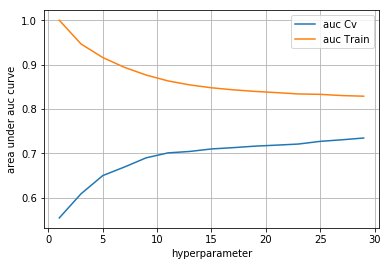

In [62]:
plt.plot(k, aucCv, label = 'auc Cv')
plt.plot(k, aucTrain, label = 'auc Train')
plt.xlabel('hyperparameter')
plt.ylabel('area under auc curve')
plt.grid()
plt.legend()
plt.show()

### Observation :-
for k = 29 we get maximum cv roc value

In [67]:
mnbBow = KNeighborsClassifier(n_neighbors= 29, algorithm = 'brute')
mnbBow.fit(trainBowBrute, yTrainBrute)

pred_prob = mnbBow.predict_proba(trainBowBrute)
pred_prob1 = mnbBow.predict_proba(testBowBrute)

fpr1, tpr1, thresholds = metrics.roc_curve(yTrainBrute, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(yTestBrute, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(testBowBrute)

0.7151668057279776

In [69]:

y_pred = mnbBow.predict(testBowBrute)

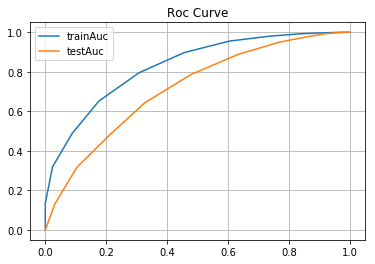

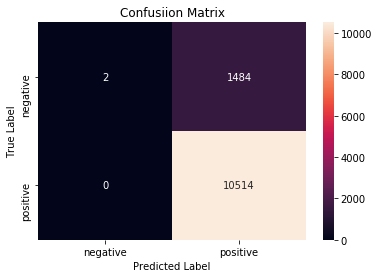

In [70]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yTestBrute, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [71]:
tableData.add_row(['BOW', "BRUTE", 29, auc2])

In [72]:
print(tableData)

+------------+-------+----+--------------------+
| Vectorizer | Model | K  |        AUC         |
+------------+-------+----+--------------------+
|    BOW     | BRUTE | 29 | 0.7151668057279776 |
+------------+-------+----+--------------------+


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [73]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

k = [i for i in range(1,30,2)]
aucTrain = []
aucCv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors= i, algorithm = 'brute')
    model.fit(trainTfBrute, yTrainBrute)
    
    predTrain = model.predict_proba(trainTfBrute)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTrainBrute, predTrain[:,1])
    aucTrain.append(metrics.auc(fpr, tpr))
    
    predCv = model.predict_proba(cvTfBrute)
    
    fpr, tpr, thresholds = metrics.roc_curve(yCvBrute, predCv[:,1])
    aucCv.append(metrics.auc(fpr, tpr))
    print(i, " neighour done")

1  neighour done
3  neighour done
5  neighour done
7  neighour done
9  neighour done
11  neighour done
13  neighour done
15  neighour done
17  neighour done
19  neighour done
21  neighour done
23  neighour done
25  neighour done
27  neighour done
29  neighour done


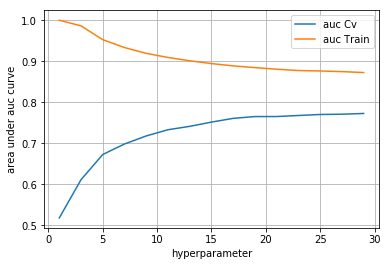

In [74]:
plt.plot(k, aucCv, label = 'auc Cv')
plt.plot(k, aucTrain, label = 'auc Train')
plt.xlabel('hyperparameter')
plt.ylabel('area under auc curve')
plt.grid()
plt.legend()
plt.show()

### Observation :-
for k = 29 we get maximum cv roc value

In [75]:
mnbBow = KNeighborsClassifier(n_neighbors= 29, algorithm = 'brute')
mnbBow.fit(trainTfBrute, yTrainBrute)

pred_prob = mnbBow.predict_proba(trainTfBrute)
pred_prob1 = mnbBow.predict_proba(testTfBrute)

fpr1, tpr1, thresholds = metrics.roc_curve(yTrainBrute, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(yTestBrute, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(testTfBrute)

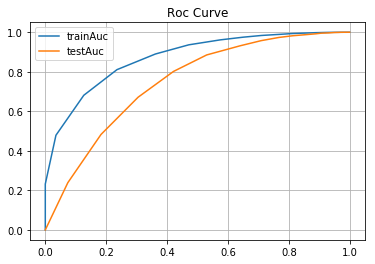

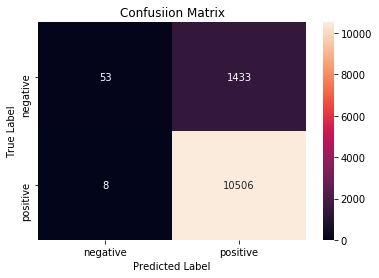

In [76]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yTestBrute, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [78]:
tableData.add_row(['Tfidf', "BRUTE", 29, auc2])

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [79]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

k = [i for i in range(1,30,2)]
aucTrain = []
aucCv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors= i, algorithm = 'brute')
    model.fit(trainAvgBrute, yTrainBrute)
    
    predTrain = model.predict_proba(trainAvgBrute)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTrainBrute, predTrain[:,1])
    aucTrain.append(metrics.auc(fpr, tpr))
    
    predCv = model.predict_proba(cvAvgBrute)
    
    fpr, tpr, thresholds = metrics.roc_curve(yCvBrute, predCv[:,1])
    aucCv.append(metrics.auc(fpr, tpr))
    print(i, " neighour done")

1  neighour done
3  neighour done
5  neighour done
7  neighour done
9  neighour done
11  neighour done
13  neighour done
15  neighour done
17  neighour done
19  neighour done
21  neighour done
23  neighour done
25  neighour done
27  neighour done
29  neighour done


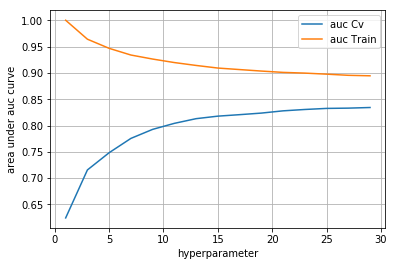

In [80]:
plt.plot(k, aucCv, label = 'auc Cv')
plt.plot(k, aucTrain, label = 'auc Train')
plt.xlabel('hyperparameter')
plt.ylabel('area under auc curve')
plt.grid()
plt.legend()
plt.show()

### Observation :-
for k = 29 we get maximum cv roc value

In [81]:
mnbBow = KNeighborsClassifier(n_neighbors= 29, algorithm = 'brute')
mnbBow.fit(trainAvgBrute, yTrainBrute)

pred_prob = mnbBow.predict_proba(trainAvgBrute)
pred_prob1 = mnbBow.predict_proba(testAvgBrute)

fpr1, tpr1, thresholds = metrics.roc_curve(yTrainBrute, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(yTestBrute, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(testAvgBrute)

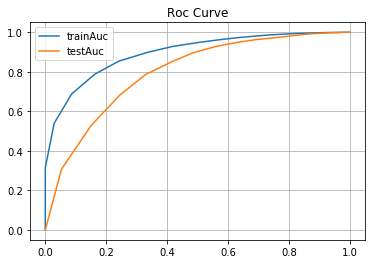

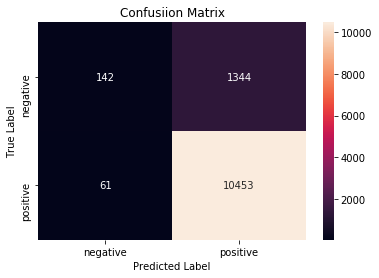

In [82]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yTestBrute, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [84]:
tableData.add_row(['Avg W2v', "BRUTE", 29, auc2])

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [85]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

k = [i for i in range(1,30,2)]
aucTrain = []
aucCv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors= i, algorithm = 'brute')
    model.fit(trainTfW2vBrute, yTrainBrute)
    
    predTrain = model.predict_proba(trainTfW2vBrute)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTrainBrute, predTrain[:,1])
    aucTrain.append(metrics.auc(fpr, tpr))
    
    predCv = model.predict_proba(cvTfW2vBrute)
    
    fpr, tpr, thresholds = metrics.roc_curve(yCvBrute, predCv[:,1])
    aucCv.append(metrics.auc(fpr, tpr))
    print(i, " neighour done")

1  neighour done
3  neighour done
5  neighour done
7  neighour done
9  neighour done
11  neighour done
13  neighour done
15  neighour done
17  neighour done
19  neighour done
21  neighour done
23  neighour done
25  neighour done
27  neighour done
29  neighour done


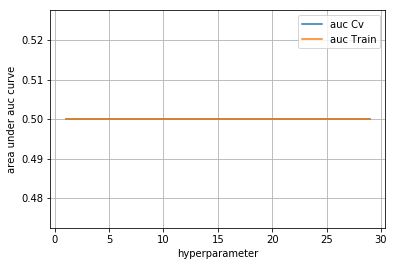

In [86]:
plt.plot(k, aucCv, label = 'auc Cv')
plt.plot(k, aucTrain, label = 'auc Train')
plt.xlabel('hyperparameter')
plt.ylabel('area under auc curve')
plt.grid()
plt.legend()
plt.show()

### Observation :-
nothing important concluded so i am taking k - 29

In [87]:
mnbBow = KNeighborsClassifier(n_neighbors= 29, algorithm = 'brute')
mnbBow.fit(trainTfW2vBrute, yTrainBrute)

pred_prob = mnbBow.predict_proba(trainTfW2vBrute)
pred_prob1 = mnbBow.predict_proba(testTfW2vBrute)

fpr1, tpr1, thresholds = metrics.roc_curve(yTrainBrute, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(yTestBrute, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(testTfW2vBrute)

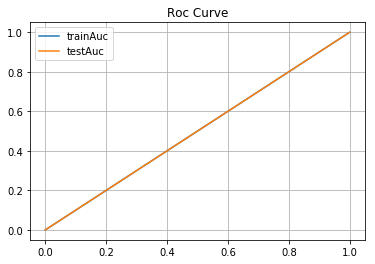

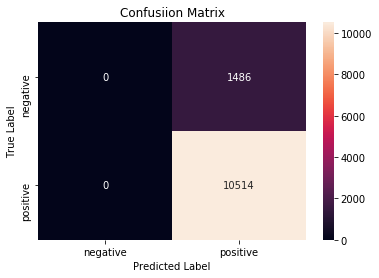

In [88]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yTestBrute, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [89]:
tableData.add_row(['Tfidf W2v', "BRUTE", 29, auc2])

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [90]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

k = [i for i in range(1,30,2)]
aucTrain = []
aucCv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors= i, algorithm = 'kd_tree')
    model.fit(trainBowKd, yTrainKd)
    
    predTrain = model.predict_proba(trainBowKd)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTrainKd, predTrain[:,1])
    aucTrain.append(metrics.auc(fpr, tpr))
    
    predCv = model.predict_proba(cvBowKd)
    
    fpr, tpr, thresholds = metrics.roc_curve(yCvKd, predCv[:,1])
    aucCv.append(metrics.auc(fpr, tpr))
    print(i, " neighour done")

1  neighour done
3  neighour done
5  neighour done
7  neighour done
9  neighour done
11  neighour done
13  neighour done
15  neighour done
17  neighour done
19  neighour done
21  neighour done
23  neighour done
25  neighour done
27  neighour done
29  neighour done


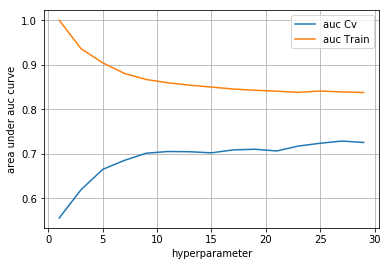

In [91]:
plt.plot(k, aucCv, label = 'auc Cv')
plt.plot(k, aucTrain, label = 'auc Train')
plt.xlabel('hyperparameter')
plt.ylabel('area under auc curve')
plt.grid()
plt.legend()
plt.show()

### Observation :-
for k = 27 we get maximum cv roc value

In [94]:
mnbBow = KNeighborsClassifier(n_neighbors= 27, algorithm = 'kd_tree')
mnbBow.fit(trainBowKd, yTrainKd)

pred_prob = mnbBow.predict_proba(trainBowKd)
pred_prob1 = mnbBow.predict_proba(testBowKd)

fpr1, tpr1, thresholds = metrics.roc_curve(yTrainKd, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(yTestKd, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(testBowKd)

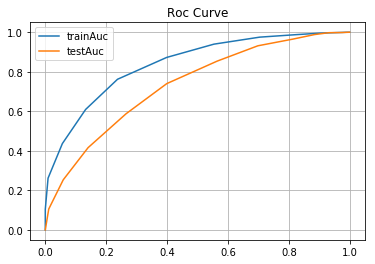

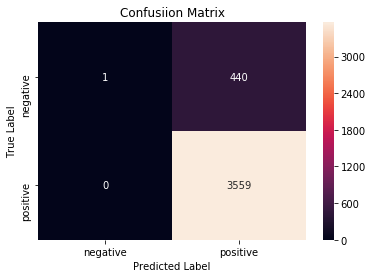

In [96]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yTestKd, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [98]:
tableData.add_row(['BOW', "kd tree", 27, auc2])

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [103]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

k = [i for i in range(1,30,2)]
aucTrain = []
aucCv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors= i, algorithm = 'kd_tree')
    model.fit(trainTfKd, yTrainKd)
    
    predTrain = model.predict_proba(trainTfKd)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTrainKd, predTrain[:,1])
    aucTrain.append(metrics.auc(fpr, tpr))
    
    predCv = model.predict_proba(cvTfKd)
    
    fpr, tpr, thresholds = metrics.roc_curve(yCvKd, predCv[:,1])
    aucCv.append(metrics.auc(fpr, tpr))
    print(i, " neighour done")

1  neighour done
3  neighour done
5  neighour done
7  neighour done
9  neighour done
11  neighour done
13  neighour done
15  neighour done
17  neighour done
19  neighour done
21  neighour done
23  neighour done
25  neighour done
27  neighour done
29  neighour done


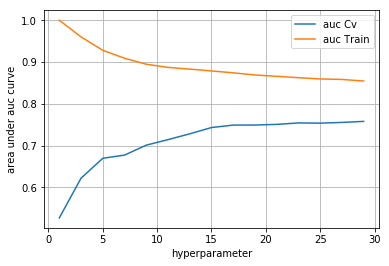

In [104]:
plt.plot(k, aucCv, label = 'auc Cv')
plt.plot(k, aucTrain, label = 'auc Train')
plt.xlabel('hyperparameter')
plt.ylabel('area under auc curve')
plt.grid()
plt.legend()
plt.show()

### Observation :-
for k = 29 we get maximum cv roc value

In [106]:
mnbBow = KNeighborsClassifier(n_neighbors= 29, algorithm = 'kd_tree')
mnbBow.fit(trainTfKd, yTrainKd)

pred_prob = mnbBow.predict_proba(trainTfKd)
pred_prob1 = mnbBow.predict_proba(testTfKd)

fpr1, tpr1, thresholds = metrics.roc_curve(yTrainKd, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(yTestKd, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(testTfKd)

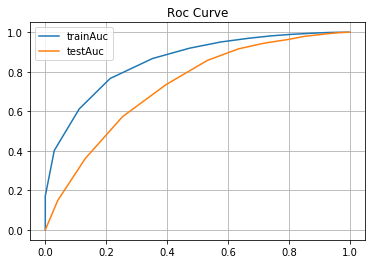

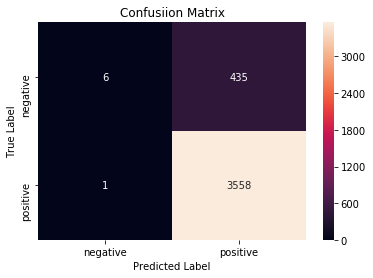

In [107]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yTestKd, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [108]:
tableData.add_row(['Tf idf', "kd tree", 29, auc2])

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [109]:
k = [i for i in range(1,30,2)]
aucTrain = []
aucCv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors= i, algorithm = 'kd_tree')
    model.fit(trainAvgKd, yTrainKd)
    
    predTrain = model.predict_proba(trainAvgKd)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTrainKd, predTrain[:,1])
    aucTrain.append(metrics.auc(fpr, tpr))
    
    predCv = model.predict_proba(cvAvgKd)
    
    fpr, tpr, thresholds = metrics.roc_curve(yCvKd, predCv[:,1])
    aucCv.append(metrics.auc(fpr, tpr))
    print(i, " neighour done")

1  neighour done
3  neighour done
5  neighour done
7  neighour done
9  neighour done
11  neighour done
13  neighour done
15  neighour done
17  neighour done
19  neighour done
21  neighour done
23  neighour done
25  neighour done
27  neighour done
29  neighour done


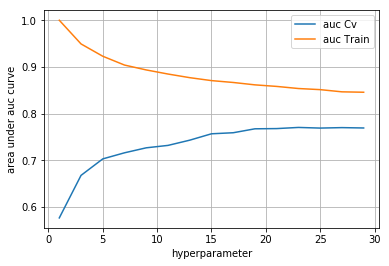

In [110]:
plt.plot(k, aucCv, label = 'auc Cv')
plt.plot(k, aucTrain, label = 'auc Train')
plt.xlabel('hyperparameter')
plt.ylabel('area under auc curve')
plt.grid()
plt.legend()
plt.show()

### Observation :-
for k = 27 we get maximum cv roc value

In [112]:
mnbBow = KNeighborsClassifier(n_neighbors= 27, algorithm = 'kd_tree')
mnbBow.fit(trainAvgKd, yTrainKd)

pred_prob = mnbBow.predict_proba(trainAvgKd)
pred_prob1 = mnbBow.predict_proba(testAvgKd)

fpr1, tpr1, thresholds = metrics.roc_curve(yTrainKd, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(yTestKd, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(testAvgKd)

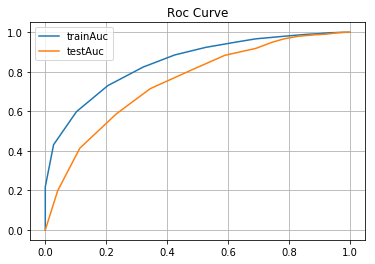

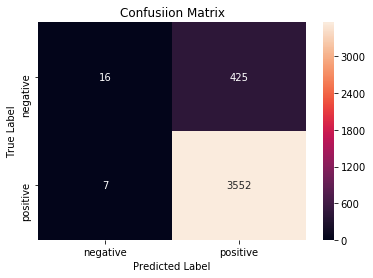

In [113]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yTestKd, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [114]:
tableData.add_row(['Avg W2v', "kd tree", 27, auc2])

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [115]:
k = [i for i in range(1,30,2)]
aucTrain = []
aucCv = []
for i in k:
    model = KNeighborsClassifier(n_neighbors= i, algorithm = 'kd_tree')
    model.fit(trainTfW2vKd, yTrainKd)
    
    predTrain = model.predict_proba(trainTfW2vKd)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTrainKd, predTrain[:,1])
    aucTrain.append(metrics.auc(fpr, tpr))
    
    predCv = model.predict_proba(cvTfW2vKd)
    
    fpr, tpr, thresholds = metrics.roc_curve(yCvKd, predCv[:,1])
    aucCv.append(metrics.auc(fpr, tpr))
    print(i, " neighour done")

1  neighour done
3  neighour done
5  neighour done
7  neighour done
9  neighour done
11  neighour done
13  neighour done
15  neighour done
17  neighour done
19  neighour done
21  neighour done
23  neighour done
25  neighour done
27  neighour done
29  neighour done


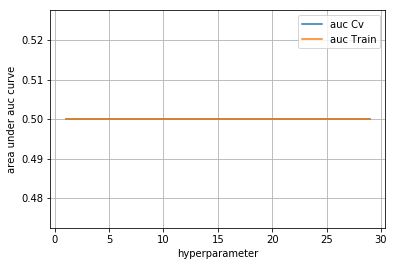

In [116]:
plt.plot(k, aucCv, label = 'auc Cv')
plt.plot(k, aucTrain, label = 'auc Train')
plt.xlabel('hyperparameter')
plt.ylabel('area under auc curve')
plt.grid()
plt.legend()
plt.show()

### Observation :-
nothing important concluded so i am taking k = 29

In [117]:
mnbBow = KNeighborsClassifier(n_neighbors= 29, algorithm = 'kd_tree')
mnbBow.fit(trainTfW2vKd, yTrainKd)

pred_prob = mnbBow.predict_proba(trainTfW2vKd)
pred_prob1 = mnbBow.predict_proba(testTfW2vKd)

fpr1, tpr1, thresholds = metrics.roc_curve(yTrainKd, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(yTestKd, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(testTfW2vKd)

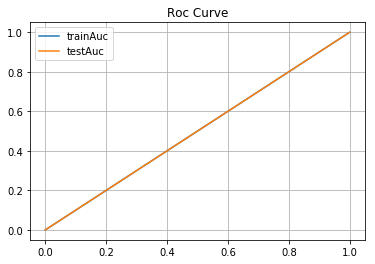

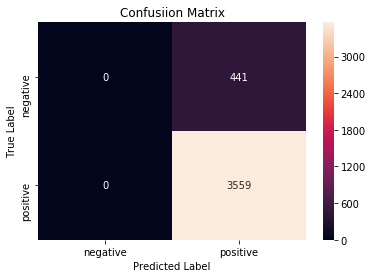

In [118]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(yTestKd, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [119]:
tableData.add_row(['Tf w2v', "kd tree", 29, auc2])

# [6] Conclusions

In [120]:
print(tableData)

+------------+---------+----+--------------------+
| Vectorizer |  Model  | K  |        AUC         |
+------------+---------+----+--------------------+
|    BOW     |  BRUTE  | 29 | 0.7151668057279776 |
|   Tfidf    |  BRUTE  | 29 | 0.7477223216573889 |
|  Avg W2v   |  BRUTE  | 29 | 0.7958826800438613 |
| Tfidf W2v  |  BRUTE  | 29 |        0.5         |
|    BOW     | kd tree | 27 | 0.7327948881154036 |
|   Tf idf   | kd tree | 29 | 0.7284836946860791 |
|  Avg W2v   | kd tree | 27 | 0.7467010593691442 |
|   Tf w2v   | kd tree | 29 |        0.5         |
+------------+---------+----+--------------------+


1. for brute knn we get maximum auc in the avg w2v with k = 29
2. for kd-tree knn we get  maximum auc in the avg w2v with k = 27